In [ ]:
# ==========================================
# 1. 环境配置与导入
# ==========================================
import pandas as pd
import numpy as np
import pickle
import openai
import matplotlib.pyplot as plt
import re
import traceback
import time
import warnings

# 忽略 'Mean of empty slice' 类型的 RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice")

# ==========================================
# DeepSeek API 配置
# ==========================================

openai.api_key = "YOUR_API_KEY" 
openai.api_base = "https://api.deepseek.com"

# ==========================================
# 通用 LLM 调用函数
# ==========================================
def call_llm(messages, model="deepseek-chat", temperature=0.7):
    """
    通用的大模型调用接口
    注意：model 参数默认值已改为 'deepseek-chat' (DeepSeek V3)
    """
    try:
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
            temperature=temperature,
            stream=False
        )
        return response.choices[0].message['content']
    except Exception as e:
        print(f"API 调用失败: {e}")
        # 打印更多错误细节以便调试
        import traceback
        traceback.print_exc()
        return None

print("DeepSeek 环境配置完成。")

DeepSeek 环境配置完成。


In [2]:
# ==========================================
# 2. 数据加载
# ==========================================
def load_data_from_pkl():
    """读取本地 pkl 文件 (根据题目要求的变量名)"""
    # 假设文件在当前目录下
    with open('./data/S_DQ_OPEN.pkl', 'rb') as f: df_open = pickle.load(f)
    with open('./data/S_DQ_HIGH.pkl', 'rb') as f: df_high = pickle.load(f)
    with open('./data/S_DQ_LOW.pkl', 'rb') as f: df_low = pickle.load(f)
    with open('./data/S_DQ_CLOSE.pkl', 'rb') as f: df_close = pickle.load(f)
    with open('./data/S_DQ_VOLUME.pkl', 'rb') as f: df_volume = pickle.load(f)
    with open('./data/S_DQ_ADJCLOSE.pkl', 'rb') as f: df_adjclose = pickle.load(f) # 用于计算收益率
    print("本地数据加载成功。")
    return df_open, df_high, df_low, df_close, df_volume, df_adjclose

# 加载数据
S_DQ_OPEN, S_DQ_HIGH, S_DQ_LOW, S_DQ_CLOSE, S_DQ_VOLUME, S_DQ_ADJCLOSE = load_data_from_pkl()

# 数据预处理：计算全市场收益率（用于计算 IC 和回测）
# 收益率 = (下期收盘价 / 本期收盘价) - 1
df_returns = S_DQ_ADJCLOSE.pct_change(fill_method=None).shift(-1) 

print("数据准备就绪。")

本地数据加载成功。
数据准备就绪。


In [3]:
# ==========================================
# 3. FactorGPT: 因子生成智能体
# ==========================================

class FactorGPT_Agent:
    def __init__(self):
        self.role_prompt = """
        你是一个专业的量化因子研究员。你的任务是基于给定的基础量价数据，设计有效的量化选股因子。
        
        【可用数据字段变量名】
        - S_DQ_OPEN: 开盘价
        - S_DQ_HIGH: 最高价
        - S_DQ_LOW: 最低价
        - S_DQ_CLOSE: 收盘价
        - S_DQ_VOLUME: 成交量
        
        【可用算子】
        - 基础: +, -, *, /, log, sqrt, abs, sign, ^ (幂)
        - 时序: ts_mean(df, n), ts_std(df, n), ts_corr(x, y, n), ts_max(df, n), ts_min(df, n), delay(df, n)
        - 截面: rank(df) (输出0-1), scale(df)
        - 逻辑: (cond) ? true_val : false_val

        【因子示例 (Few-Shot)】
        学习以下优秀因子的构建逻辑和表达式结构：
        
        示例1 (价量相关性):
        因子名称: 量价背离因子
        因子含义: 计算过去10天收盘价与成交量的相关性，并除以成交量波动率，捕捉量价背离程度。
        数学表达式: ts_corr(S_DQ_CLOSE, S_DQ_VOLUME, 10) / ts_std(S_DQ_VOLUME, 10)
        
        示例2 (反转与波动):
        因子名称: 高波反转因子
        因子含义: 寻找过去20天涨幅大且波动率高的股票，预期其未来会下跌（做空）。
        数学表达式: -1 * ts_mean(S_DQ_CLOSE/delay(S_DQ_CLOSE, 5)-1, 5) * ts_std(S_DQ_CLOSE/delay(S_DQ_CLOSE, 1)-1, 20)
        
        示例3 (路径特质):
        因子名称: 价格路径效率
        因子含义: 衡量价格走势的顺滑程度，计算过去20天绝对涨幅除以每日涨幅绝对值之和。
        数学表达式: abs(S_DQ_CLOSE / delay(S_DQ_CLOSE, 20) - 1) / ts_sum(abs(S_DQ_CLOSE / delay(S_DQ_CLOSE, 1) - 1), 20)

        【输出格式要求】
        请严格按照以下格式输出（不要输出多余的解释）：
        
        因子名称: [因子名]
        因子含义: [简短描述]
        数学表达式: [表达式]
        """

    def generate_factor(self, feedback_suggestion=None):
        """
        生成因子
        :param feedback_suggestion: 来自 EvalGPT 的优化建议
        """
        messages = [{"role": "system", "content": self.role_prompt}]
        
        if feedback_suggestion:
            user_content = f"""
            上一轮的回测评估意见如下，请根据此建议优化已有因子或生成一个新的因子：
            "{feedback_suggestion}"
            """
        else:
            user_content = """
            请生成一个创新的量价因子。
            
            建议方向（任选其一）：
            1. **量价去趋势**：使用 rank 或 ts_mean 去除价格和成交量的长期趋势，只看短期突变。
            2. **高阶矩特征**：尝试使用偏度(ts_skew)或峰度(ts_kurt)捕捉极端收益风险。
            3. **量稳价升**：寻找价格上涨但成交量波动率(ts_std)较低的稳健股票。
            
            注意：**必须对成交量、价格进行标准化处理**（如除以过去20日均值），避免直接使用原始 S_DQ_VOLUME。
            """
            
        messages.append({"role": "user", "content": user_content})
        
        response = call_llm(messages, temperature=0.9)
        return response

factor_gpt = FactorGPT_Agent()

In [ ]:
# ==========================================
# 4. CodeGPT: 代码生成与执行智能体
# ==========================================

class CodeGPT_Agent:
    def __init__(self):
        self.role_prompt = """
        你是一个精通高性能计算的 Python 量化工程师。你的任务是将数学表达式转化为高效的可执行代码。
        
        输入数据：
        全局变量中已存在 dataframe: S_DQ_OPEN, S_DQ_HIGH, S_DQ_LOW, S_DQ_CLOSE, S_DQ_VOLUME (Index=Time, Columns=Stock)。
        
        【要求】
        1. **核心原则**：代码必须能够处理 (3000x5000) 级别的数据。
        2. **禁用列表**：
           - ** `for` 循环**。
           - ** `.apply()`** (包括 `rolling().apply()`)，这会导致极慢的逐行运算。
        3. **工具选择**：
           - 优先使用 **NumPy** 函数 (如 `np.log`, `np.where`, `np.sign`) 处理元素级运算。
           - 简单逻辑直接使用 Pandas 内置算子 (如 `.rolling(w).mean()`, `.rank(axis=1)`).
           - 涉及复杂滚动计算(如滚动Rank)时，请寻找替代的向量化算法或简化逻辑。
        4. **收益率计算**：必须使用 `S_DQ_CLOSE.pct_change(fill_method=None)`。
        5. **清洗**：计算结果中出现的 inf 替换为 NaN。

        【数据处理守则】
        1. **严禁使用原始成交量**：
           - 必须转换为 **量比**：`vol_ratio = S_DQ_VOLUME / S_DQ_VOLUME.rolling(20).mean()`
           - 或者 **换手率代理**：`turnover = S_DQ_VOLUME / S_DQ_VOLUME.rolling(252).mean()` (近似)
        2. **严禁使用原始价格差**：用 `(CLOSE - OPEN) / OPEN` 或 `pct_change()`。
        3. **必须标准化**：函数返回前，必须对最终因子进行 **Z-Score 标准化** 和 **去极值**。
        
        【代码模板】
        def calculate_factor():
            import numpy as np
            # 1. 预计算中间变量 (使用 numpy 向量化)
            # 2. 执行核心逻辑
            # 3. 返回 DataFrame
            return factor
        """

    def clean_code(self, raw_text):
        """清洗 LLM 输出的代码，去除 markdown 符号"""
        code = raw_text.strip()
        code = re.sub(r'^```python', '', code, flags=re.MULTILINE)
        code = re.sub(r'^```', '', code, flags=re.MULTILINE)
        return code.strip()

    def generate_and_execute(self, factor_info, max_retries=3):
        """
        生成代码并执行，包含自动 Debug 循环
        """
        messages = [
            {"role": "system", "content": self.role_prompt},
            {"role": "user", "content": f"请将以下因子逻辑转化为代码：\n{factor_info}"}
        ]
        
        current_retry = 0
        execution_success = False
        factor_values = None
        code_content = ""
        
        while current_retry < max_retries and not execution_success:
            # 1. 生成/修复代码
            print(f"CodeGPT 正在{'生成' if current_retry == 0 else '修复'}代码 (尝试 {current_retry + 1}/{max_retries})...")
            response = call_llm(messages, temperature=0.0)
            code_content = self.clean_code(response)
            
            # 2. 尝试执行
            try:
                # 创建局部命名空间，注入数据
                local_scope = {}
                global_scope = globals() # 注入全局变量中的 DataFrame
                
                # 执行定义函数的代码
                exec(code_content, global_scope, local_scope)
                
                # 调用函数获取结果
                if 'calculate_factor' not in local_scope:
                    raise ValueError("代码中未定义 calculate_factor 函数")
                
                factor_values = local_scope['calculate_factor']()
                
                # 简单检查结果有效性
                if not isinstance(factor_values, pd.DataFrame):
                    raise TypeError("函数未返回 DataFrame")
                if factor_values.shape != S_DQ_CLOSE.shape:
                    raise ValueError(f"返回维度 {factor_values.shape} 与原始数据不符")
                
                execution_success = True
                print("CodeGPT 执行成功！")
                
            except Exception as e:
                error_msg = traceback.format_exc()
                print(f"执行报错: {e}")
                
                # 将报错信息喂回给 LLM
                messages.append({"role": "assistant", "content": code_content})
                messages.append({
                    "role": "user", 
                    "content": f"代码执行报错，请修复代码。报错信息：\n{error_msg}\n请直接给出修复后的完整代码。"
                })
                current_retry += 1
                
        return code_content, factor_values, execution_success

code_gpt = CodeGPT_Agent()

In [ ]:
# ==========================================
# 5. EvalGPT: 评估与优化智能体
# ==========================================

class EvalGPT_Agent:
    def __init__(self):
        pass
        
    def _get_long_short_returns(self, factor_df, returns_df, groups=5):
        """辅助函数：计算多空策略的日收益率序列"""
        # 1. 因子对齐
        valid_factor = factor_df.copy()
        valid_returns = returns_df.copy()
        
        # 2. 每日分层 (Rank & Quintile)
        factor_ranks = valid_factor.rank(axis=1, pct=True, method='first')
        
        # 3. 提取多头和空头
        # Group 5 (Long): (0.8, 1.0]
        long_mask = (factor_ranks > (groups - 1) / groups)
        # Group 1 (Short): [0.0, 0.2]
        short_mask = (factor_ranks <= 1 / groups)
        
        # 4. 计算平均收益
        long_ret = valid_returns[long_mask].mean(axis=1).fillna(0)
        short_ret = valid_returns[short_mask].mean(axis=1).fillna(0)
        
        # 5. 多空收益 = 多头 - 空头
        ls_ret = long_ret - short_ret
        return ls_ret

    def calculate_metrics(self, factor_df, returns_df):
        """计算 IC, RankIC 以及 收益类指标"""
        # --- 原有 IC 计算 ---
        rank_ic_series = factor_df.corrwith(returns_df, axis=1, method='spearman')
        ic_series = factor_df.corrwith(returns_df, axis=1, method='pearson')
        
        rank_ic_mean = rank_ic_series.mean()
        rank_ic_ir = rank_ic_mean / rank_ic_series.std() if rank_ic_series.std() != 0 else 0
        
        # --- 收益类指标计算 ---
        ls_ret = self._get_long_short_returns(factor_df, returns_df)
        
        # 1. 年化收益率 (这里用单利近似或复利)
        # 年化 = (1 + 总收益)^(252/天数) - 1
        cum_ret = (1 + ls_ret).cumprod().iloc[-1]
        days = len(ls_ret)
        ann_ret = (cum_ret ** (252/days) - 1) if days > 0 else 0
        
        # 2. 夏普比率 (假设无风险利率为0)
        # Sharpe = mean / std * sqrt(252)
        sharpe = (ls_ret.mean() / ls_ret.std()) * np.sqrt(252) if ls_ret.std() != 0 else 0
        
        # 3. 最大回撤
        nav = (1 + ls_ret).cumprod()
        running_max = nav.cummax()
        drawdown = (nav - running_max) / running_max
        max_dd = drawdown.min()
        
        return {
            "RankIC Mean": rank_ic_mean,
            "RankIC IR": rank_ic_ir,
            "IC Mean": ic_series.mean(),
            "Long-Short Ann Ret": ann_ret,
            "Sharpe Ratio": sharpe,
            "Max Drawdown": max_dd
        }, rank_ic_series

    def plot_layered_backtest(self, factor_df, returns_df, groups=5):
        """
        绘制因子分层回测净值曲线
        """
        import matplotlib.pyplot as plt
        
        # 1. 因子对齐与清洗
        # 确保因子和收益率索引对齐
        valid_factor = factor_df.copy()
        valid_returns = returns_df.copy()
        
        # 2. 每日分层
        # rank(axis=1) 对每一天截面进行排名，pct=True 归一化到 0~1
        factor_ranks = valid_factor.rank(axis=1, pct=True, method='first')
        
        nav_data = {}
        
        # 3. 计算各层收益
        for i in range(groups):
            # 定义层级区间，5层：0-0.2, 0.2-0.4 ...
            lower_bound = i / groups
            upper_bound = (i + 1) / groups
            
            # 生成布尔掩码：选出该层级的股票
            mask = (factor_ranks > lower_bound) & (factor_ranks <= upper_bound)
            
            # 计算该层平均收益（等权）
            # 这里的 returns_df 已经是 shift(-1) 过的下期收益率
            layer_ret = valid_returns[mask].mean(axis=1).fillna(0)
            
            # 计算净值曲线 (Cumulative Return)
            nav_data[f'Group {i+1}'] = (1 + layer_ret).cumprod()
            
        # 4. 绘图
        nav_df = pd.DataFrame(nav_data)
        
        # 计算多空收益 (Group 5 - Group 1) 并加入图表
        nav_df['Long-Short'] = nav_df[f'Group {groups}'] / nav_df['Group 1']
        
        plt.figure(figsize=(12, 6))
        for col in nav_df.columns:
            # 突出显示多空曲线
            linewidth = 3 if col == 'Long-Short' else 1.5
            plt.plot(nav_df.index, nav_df[col], label=col, linewidth=linewidth)
            
        plt.title(f'Factor Layered Backtest ({groups} Groups)', fontsize=15)
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # 返回多空年化收益作为额外指标
        ls_ret = nav_df['Long-Short'].iloc[-1] ** (252/len(nav_df)) - 1
        return ls_ret

    def evaluate_and_suggest(self, factor_info, code, metrics):
        prompt = f"""
        你是一个严格的量化因子评审员。
        
        当前因子信息：
        {factor_info}
        
        回测绩效：
        1. **预测能力 (IC)**:
           - RankIC均值: {metrics['RankIC Mean']:.4f} (通常 >0.03 为有效)
           - RankIC IR: {metrics['RankIC IR']:.4f}
           
        2. **实盘模拟 (多空对冲)**:
           - **年化收益率**: {metrics['Long-Short Ann Ret']:.2%} 
           - **夏普比率**: {metrics['Sharpe Ratio']:.2f} (通常 >1.5 为优秀)
           - **最大回撤**: {metrics['Max Drawdown']:.2%}
        
        请完成以下任务：
        1. 综合点评：结合 IC (预测性) 和 收益率 (落地性) 进行评价。
           - 如果 IC 高但收益低，可能是因为多空不对称或极值影响。
           - 如果收益高但回撤大，提示风险控制。
        2. 给出具体的优化建议。
        """
        
        messages = [{"role": "user", "content": prompt}]
        response = call_llm(messages, temperature=0.3)
        return response

eval_gpt = EvalGPT_Agent()


==================== 第 0 轮挖掘/优化 ====================
>> FactorGPT 正在思考...
生成方案:
因子名称: 量稳价升去趋势因子
因子含义: 去除价格和成交量的长期趋势，捕捉短期价格稳健上涨（价格路径效率高）且成交量波动率低的股票。
数学表达式: (abs(S_DQ_CLOSE / delay(S_DQ_CLOSE, 5) - 1) / ts_sum(abs(S_DQ_CLOSE / delay(S_DQ_CLOSE, 1) - 1), 5)) / ts_std(S_DQ_VOLUME / ts_mean(S_DQ_VOLUME, 20), 10)

>> CodeGPT 正在编写代码...
CodeGPT 正在生成代码 (尝试 1/3)...
执行报错: invalid character '：' (U+FF1A) (<string>, line 66)
CodeGPT 正在修复代码 (尝试 2/3)...
CodeGPT 执行成功！
回测结果:
  [预测能力] RankIC Mean = 0.0091, IR = 0.1057
  [实盘模拟] 多空年化 = -1.67%, 夏普 = -0.14, 最大回撤 = -59.12%


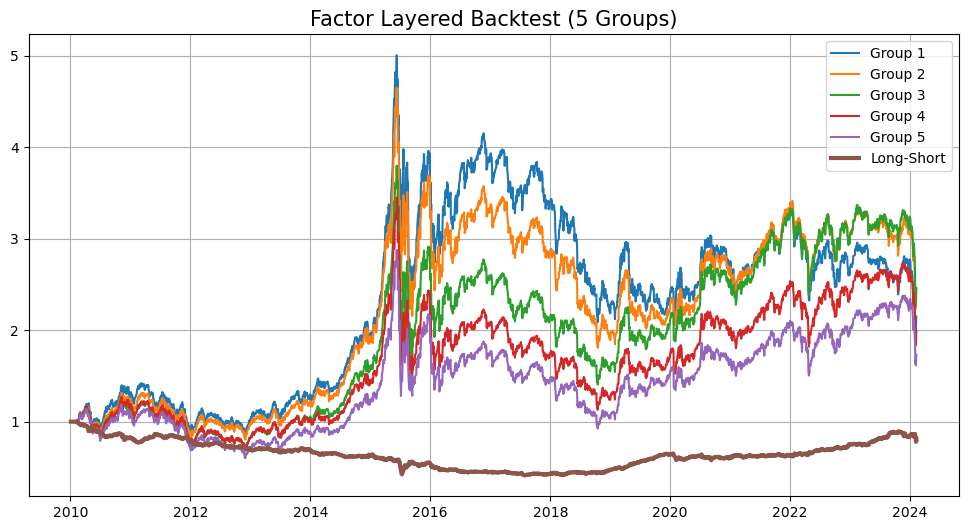


EvalGPT 点评:
### **综合点评**

该因子在**预测性**和**落地性**两个维度上均表现**极差**，是一个**无效且高风险**的因子，不具备任何实际投资价值。

1.  **预测能力 (IC) 极弱**：
    *   **RankIC均值 (0.0091)**：远低于通常认为有效的阈值（0.03）。这意味着因子值与股票未来收益之间的单调关系非常微弱，几乎没有预测能力。
    *   **RankIC IR (0.1057)**：该值极低，表明因子预测的**稳定性极差**。微弱的预测信号被巨大的噪声所淹没，导致信号不可靠。

2.  **实盘绩效 (收益率) 完全失败**：
    *   **年化收益率 (-1.67%)**：多空对冲组合不仅没有创造收益，反而产生了亏损。
    *   **夏普比率 (-0.14)**：为负值，意味着承担风险不仅没有获得补偿，反而遭受了损失。这与“优秀”的阈值（>1.5）相去甚远。
    *   **最大回撤 (-59.12%)**：这是一个**灾难性**的风险指标。在回测期间，策略净值曾从高点腰斩过半，表明因子构建的多空组合在特定市场环境下会同时失效，风险暴露高度集中，完全不具备风险控制能力。

**结论**：该因子在理论上试图捕捉“量稳价升”的短期模式，但实际表现证明其逻辑在当前市场或回测周期内**完全无效**。微弱的预测性（低IC）无法转化为正向收益，反而暴露了巨大的下行风险（负收益、巨大回撤）。因子设计可能存在根本性缺陷。

---

### **具体的优化建议**

鉴于当前因子表现极差，不建议在现有表达式上进行微调，而应进行**根本性的重构或放弃**。优化方向如下：

**1. 因子逻辑与表达式重构：**
*   **重新审视核心逻辑**：“量稳价升去趋势”本身是一个合理的直觉。问题可能出在实现方式上。分子部分（价格路径效率）和分母部分（成交量波动率）的构造、标准化以及组合方式可能均不合理。
    *   **价格效率部分**：`abs(5日收益率) / 5日绝对日收益率之和` 这个比率试图衡量价格路径的“效率”（以最小波动达到某一涨幅），但其统计性质可能不稳定，对极端值（如某日暴涨）非常敏感。可考虑替换为更稳健的指标，如：
        *   `5日收益率 / 5日收益率的标准差`

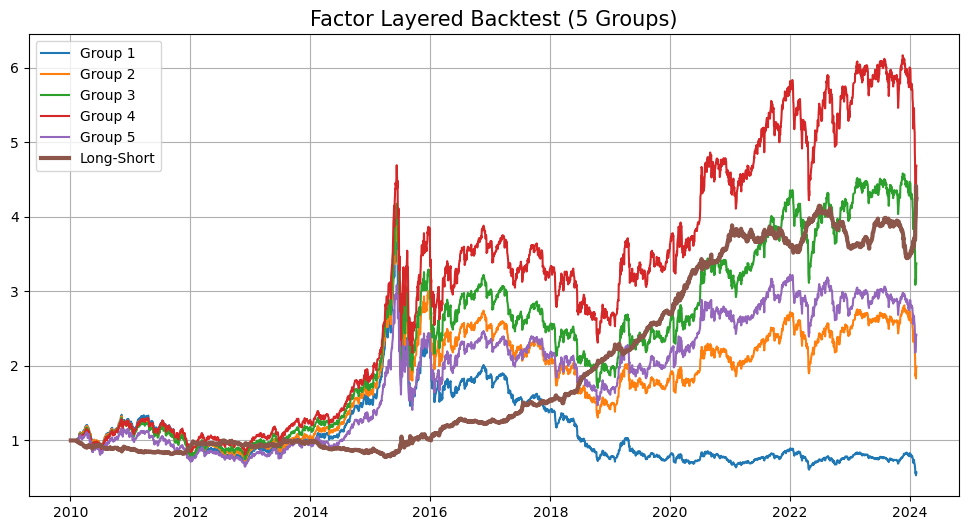


EvalGPT 点评:
### 综合点评

该因子在**预测能力**和**落地表现**上均存在显著不足，是一个**无效且风险较高**的因子，不建议直接用于实盘。

1.  **预测能力极弱**：
    *   **RankIC均值仅为0.0014**，远低于有效因子通常的阈值（>0.03）。这表明因子值与股票未来收益之间几乎没有线性预测关系。
    *   **RankIC IR为0.0150**，同样极低，说明因子预测能力不仅微弱，而且极不稳定，信噪比很差。

2.  **实盘表现平庸且风险突出**：
    *   **年化收益率10.75%** 和 **夏普比率1.03** 在扣除交易成本、冲击成本后，实际收益将大打折扣，吸引力有限。
    *   **最大回撤高达-24.26%** 是核心问题。对于一个预测能力本就很弱的因子，如此大的回撤意味着它在市场不利期可能产生巨大亏损，风险收益比极差。夏普比率未能充分反映这一尾部风险。

**结论**：该因子试图捕捉“价涨稳量”的逻辑，但当前的实现方式（简单的夏普比率与变异系数倒数的乘积）未能有效提取具有预测性的信号。其微弱的预测性（IC）直接导致了平庸的收益和不可接受的回撤风险，是一个失败的因子。

---

### 具体优化建议

鉴于当前因子基础薄弱，建议从**逻辑深化**、**构造方法**和**风险控制**三个层面进行彻底优化或重构，而非小修小补。

**1. 逻辑深化与因子重构**
*   **解构与独立测试**：分别测试“5日价格夏普比率”和“10日成交量稳定度”两个子因子的独立预测能力（IC）。很可能其中一个或两个都无效，需要找到失效原因。
*   **改进价格效率度量**：
    *   考虑使用 **残差波动率**（剔除市场或行业波动后的特异性波动）代替简单收益率标准差，更能捕捉个股自身的价格效率。
    *   尝试不同的时间窗口（如3日、8日、20日），并测试其与未来不同持有期收益的相关性。
    *   引入 **自适应波动率估计**（如EWMA模型）或使用 **稳健标准差**（如MAD）以降低极端收益率的影响。
*   **改进成交量稳定度度量**：
    *   “成交量稳定”的逻辑需要审视。在上涨趋势中，温和放量可能比绝对稳定更健康。可考虑构建 **“成交量趋势与价格趋势的

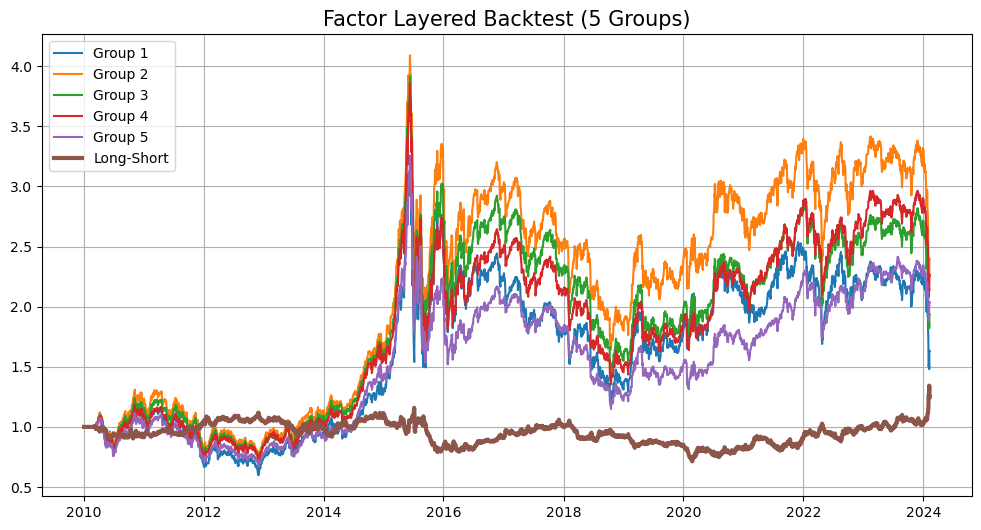


EvalGPT 点评:
### 1. 综合点评

该因子在**预测能力**和**落地表现**上均**表现不佳**，是一个**无效且高风险**的因子。

*   **预测能力（IC）极弱**：
    *   RankIC均值仅为0.0099，远低于通常认为有效的阈值（>0.03）。这表明因子值与股票未来收益的排序相关性几乎为零，不具备稳定的预测能力。
    *   RankIC IR为0.0805，同样极低，说明因子预测的稳定性很差，信号噪声比过高。IC序列的波动可能远大于其均值。

*   **实盘表现（多空对冲）完全失效**：
    *   **年化收益率**为-1.01%，意味着因子构建的多空组合不仅没有创造Alpha，反而产生了轻微的亏损。这直接印证了IC预测能力的缺失。
    *   **夏普比率**为-0.01，表明承担单位风险所获得的回报为负，投资效率极差。
    *   **最大回撤**高达-48.66%，这是一个**灾难性**的风险指标。它意味着在回测期间，该策略的净值曾从高点下跌近一半。如此巨大的回撤在实际管理中是完全不可接受的，会直接导致策略被清盘。

**核心矛盾分析**：
本因子不存在“IC高但收益低”的矛盾，因为其IC本身就极低。当前情况是**预测能力与收益表现双差**。巨大的回撤（-48.66%）与负的夏普比率（-0.01）共同指向一个结论：该因子的收益结构极不稳定，可能在少数时间段内因暴露于某种极端风险（如流动性风险、小市值风险、行业风险等）而遭遇巨额亏损，完全不具备实战价值。

### 2. 具体的优化建议

鉴于当前因子表现极差，建议进行**根本性重构或直接放弃**。若希望尝试优化，应从以下几个方向进行彻底检查与改造：

**1. 因子逻辑与构造的深度审查：**
*   **残差波动率倒数（效率指标）**：
    *   **有效性检验**：单独测试 `rank(1 / ts_std(...))` 这个子因子的IC和收益。很可能这个“价格特异性波动效率”本身就是一个无效或弱效的指标。
    *   **计算方式**：检查残差的计算方式（个股收益 - 20日均值）是否合理。是否应考虑减去市场指数或行业指数的收益，以得到真正的“特异性”波动？
    *   **稳定性**：波动率的倒数对极端值（接近0的波动率）非常敏感

/opt/anaconda3/envs/or/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


CodeGPT 执行成功！
回测结果:
  [预测能力] RankIC Mean = 0.0336, IR = 0.2106
  [实盘模拟] 多空年化 = 8.19%, 夏普 = 0.55, 最大回撤 = -44.94%


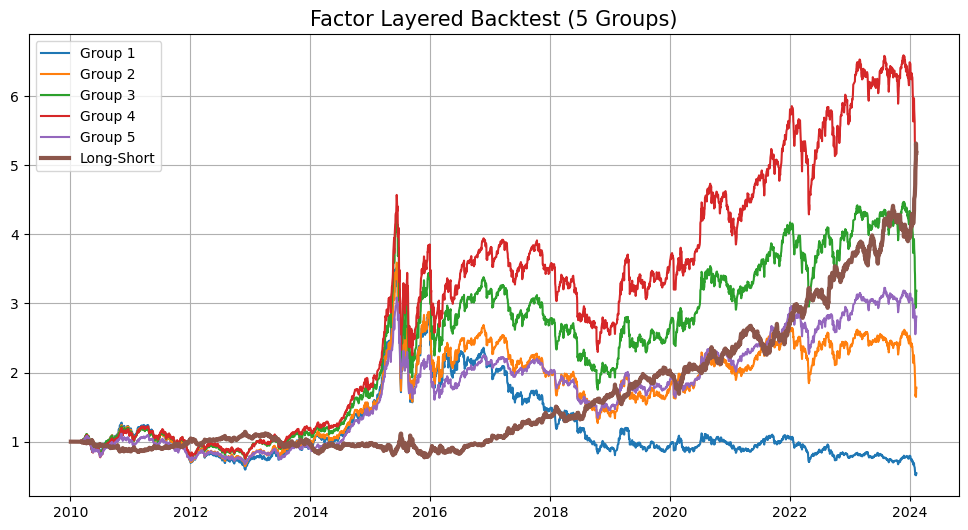


EvalGPT 点评:
### **因子综合点评**

该因子在**预测性**和**落地性**上表现出了显著的**矛盾性**和**风险性**，是一个典型的“高潜力、高风险”因子，**当前形态不适合直接用于实盘**。

1.  **预测能力 (IC) 评价：平庸**
    *   **RankIC均值 (0.0336)**：刚刚超过0.03的经验有效阈值，表明因子具有一定的预测方向性，但预测能力**偏弱**。这是一个“可用但不够强”的信号。
    *   **RankIC IR (0.2106)**：远低于0.5的基准，表明因子的预测信号**稳定性很差**，波动大，在不同时间段的有效性差异显著。这是该因子最大的软肋。

2.  **实盘绩效评价：高风险，不可接受**
    *   **年化收益率 (8.19%)**：在A股对冲策略中，此收益水平尚可，但不足以覆盖其伴随的巨大风险。
    *   **夏普比率 (0.55)**：远低于优秀线(1.5)和合格线(1.0)，表明承担单位风险所获得的回报非常低，策略效率极差。
    *   **最大回撤 (-44.94%)**：**这是致命的缺陷**。对于一个多空对冲策略，接近45%的回撤意味着策略在相当长一段时间内完全失效，风险敞口巨大，远超任何合理的风控底线。这会导致策略在实际运行中极有可能被提前终止。

**核心矛盾分析：**
因子设计逻辑（特异性波动效率+价量协同）具有经济学直觉，但绩效表现揭示出严重问题：
*   **“高IC但低Sharpe、高回撤”** 的典型模式，通常意味着因子的**多空收益严重不对称**。可能的情况是：
    *   **多头端**：选出的“高效上涨”股票确实能上涨，但涨幅有限或波动大。
    *   **空头端**：选出的“低效”股票并未如预期下跌，甚至可能反向上涨，导致空头端持续产生巨大亏损，这是造成**灾难性回撤**的主要原因。
*   价量协同的**条件引入机制 (`> 0.7`)** 可能过于激进或阈值设置不当，在波动率较低的时期（效率指标排名高）强行加入相关性信号，反而引入了噪音或错误的风险暴露。

---

### **具体的优化建议**

优化目标：**保持因子逻辑内核，大幅改善其稳定性并控制下行风险。**

**1. 核心逻辑修正与稳健化处理：**
*   *

In [6]:
# ==========================================
# 6. GPT 因子工厂主循环
# ==========================================

def run_factor_factory(iterations=2):
    """
    运行因子挖掘闭环
    :param iterations: 迭代优化次数
    """
    history = []
    suggestion = None # 初始无建议
    
    for i in range(iterations + 1):
        print(f"\n{'='*20} 第 {i} 轮挖掘/优化 {'='*20}")
        
        # ---------------------------
        # Step 1: FactorGPT 生成因子
        # ---------------------------
        print(">> FactorGPT 正在思考...")
        factor_text = factor_gpt.generate_factor(suggestion)
        print(f"生成方案:\n{factor_text[:500]}")
        
        # ---------------------------
        # Step 2: CodeGPT 生成代码并计算
        # ---------------------------
        print("\n>> CodeGPT 正在编写代码...")
        code, factor_values, success = code_gpt.generate_and_execute(factor_text)
        
        if not success:
            print("因子计算失败，跳过本轮评估。")
            suggestion = "上一次生成的因子逻辑过于复杂或语法错误导致代码无法执行，请尝试简化逻辑。"
            continue
            
        # ---------------------------
        # Step 3: EvalGPT 评估
        # ---------------------------
        metrics, ic_series = eval_gpt.calculate_metrics(factor_values, df_returns)  
        
        # 打印详细的绩效面板
        print(f"回测结果:")
        print(f"  [预测能力] RankIC Mean = {metrics['RankIC Mean']:.4f}, IR = {metrics['RankIC IR']:.4f}")
        print(f"  [实盘模拟] 多空年化 = {metrics['Long-Short Ann Ret']:.2%}, 夏普 = {metrics['Sharpe Ratio']:.2f}, 最大回撤 = {metrics['Max Drawdown']:.2%}")
        # 绘制分层回测图
        eval_gpt.plot_layered_backtest(factor_values, df_returns)
        
        # 生成优化建议
        eval_message = eval_gpt.evaluate_and_suggest(factor_text, code, metrics)
        print(f"\nEvalGPT 点评:\n{eval_message}")
        
        # 保存结果
        history.append({
            "round": i,
            "factor_text": factor_text,
            "code": code,
            "metrics": metrics,
            "eval": eval_message
        })
        
        # 将建议传递给下一轮
        suggestion = eval_message

    return history

# 运行工厂（运行 3 次初始挖掘 + 3 次优化）
history_results = run_factor_factory(iterations=3)

In [7]:
# ==========================================
# 7. 最终结果展示
# ==========================================

for item in history_results:
    print(f"\n[Round {item['round']}]")
    print(f"因子IC表现: {item['metrics']['RankIC Mean']:.4f}")
    
    # 提取因子名称
    factor_name = re.search(r"因子名称[:：]\s*(.*)", item['factor_text'])
    if factor_name:
        print(f"因子名称: {factor_name.group(1).strip()}")
        
    # 提取因子表达式
    factor_expr = re.search(r"数学表达式[:：]\s*(.*)", item['factor_text'])
    if factor_expr:
        print(f"因子表达式: {factor_expr.group(1).strip()}")
        
    print("-" * 30)

# 选出最佳因子 (按 RankIC 绝对值最大)
best_factor = max(history_results, key=lambda x: abs(x['metrics']['RankIC Mean']))

print(f"\n{'='*20} 最佳因子详情 (Round {best_factor['round']}) {'='*20}")

# 提取最佳因子的名称和表达式
best_name = re.search(r"因子名称[:：]\s*(.*)", best_factor['factor_text'])
best_expr = re.search(r"数学表达式[:：]\s*(.*)", best_factor['factor_text'])

if best_name:
    print(f"因子名称: {best_name.group(1).strip()}")
if best_expr:
    print(f"因子表达式: {best_expr.group(1).strip()}")

print(f"RankIC Mean: {best_factor['metrics']['RankIC Mean']:.4f}")

print("\n[代码实现]:")
print(best_factor['code'])
# 可以选择将表现最好的因子的代码保存下来
best_factor = max(history_results, key=lambda x: abs(x['metrics']['RankIC Mean']))
print(f"\n最佳因子代码 (Round {best_factor['round']}):")
print(best_factor['code'])


[Round 0]
因子IC表现: 0.0091
因子名称: 量稳价升去趋势因子
因子表达式: (abs(S_DQ_CLOSE / delay(S_DQ_CLOSE, 5) - 1) / ts_sum(abs(S_DQ_CLOSE / delay(S_DQ_CLOSE, 1) - 1), 5)) / ts_std(S_DQ_VOLUME / ts_mean(S_DQ_VOLUME, 20), 10)
------------------------------

[Round 1]
因子IC表现: 0.0014
因子名称: 稳健量价效率因子
因子表达式: rank(ts_mean(S_DQ_CLOSE/delay(S_DQ_CLOSE, 1)-1, 5) / ts_std(S_DQ_CLOSE/delay(S_DQ_CLOSE, 1)-1, 5)) * rank(ts_mean(S_DQ_VOLUME, 10) / ts_std(S_DQ_VOLUME, 10))
------------------------------

[Round 2]
因子IC表现: 0.0099
因子名称: 残差效率协同因子
因子表达式: rank(1 / ts_std(S_DQ_CLOSE / delay(S_DQ_CLOSE, 1) - 1 - ts_mean(S_DQ_CLOSE / delay(S_DQ_CLOSE, 1) - 1, 20), 20)) + rank(ts_corr(S_DQ_CLOSE, S_DQ_VOLUME, 10))
------------------------------

[Round 3]
因子IC表现: 0.0336
因子名称: 特异性波动效率与价量协同增强因子
因子表达式: (rank(1 / ts_std(S_DQ_CLOSE/delay(S_DQ_CLOSE, 1) - ts_mean(S_DQ_CLOSE/delay(S_DQ_CLOSE, 1), 20), 20)) + (rank(1 / ts_std(S_DQ_CLOSE/delay(S_DQ_CLOSE, 1) - ts_mean(S_DQ_CLOSE/delay(S_DQ_CLOSE, 1), 20), 20)) > 0.7) ? rank(ts_corr(S_DQ_CLO